# Example 3: Tunnel Chimney Tunnel - with obstacle

This example features a more advanced action, in which the UAV is tasked with navigating through a tunnel, followed by a chimney, followed by a tunnel

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

#import the needed libraries
import sys
sys.path.append('src/')

import numpy as np
from Path_Search import *
from Quadrotor_Load import *
import matplotlib.pylab as plt
import Node
import scipy.io as sio
import PlotPlanning


## Define the model properties

In [2]:
#define constants for the model
m = 0.5 #payload mass
L = 0.5 # length of cable
M = 1 #Quadrotor mass
g = 9.81 #Gravitational constant

#calculate the natural frequencies for input shaping
Td = 1.35
ts = Td/4
A1 = 0.5783*2 #the magnitude of the input shaping steps
A2 = 0.4217*2 + 0.5783*2 #the magnitude of the input shaping steps

## Define the action space of the planner

define the input space in the format ([z0, x0 , i0], [z1, x1, i1], [z2, x2, i3]...)

z0 is the vertical reference

x0 is the horizontal reference

i0 corresponds to the input type:
- 0 : Force command
- 1 : Velocity Command

In [3]:
#define the input space
#Input Space 2
#define the input space in the format ([y0, x0 , i0], [y1, x1, i1], [y2, x2, i3]...)

U = [np.array([[0, 0,1]]),
     np.array([[0, A1,1],[0, A1,1],[0, A2,1],[0, A2,1]]),
     np.array([[0, A2,1],[0, A2,1],[0, A2,1]]),
     np.array([[0, 2-A1,1],[0, 2-A1,1],[0, 0,1],[0, 0,1]]),
     np.array([[0, -A1,1],[0, -A1,1],[0, -A2,1],[0, -A2,1]]),
     np.array([[0, -A2,1],[0, -A2,1],[0, -A2,1]]),
     np.array([[0, -2+A1,1],[0, -2+A1,1],[0, 0,1],[0, 0,1]]),     
     np.array([[1, 0,2]]),
     np.array([[-1, 0,2]]),
     np.array([[0, 7,0],[0, 7,0],[0, 7,0],[0,-7,0],[0, -7,0],[0, -7,0]])]     


## Define the state transition function of the quadrotor-payload

In [4]:
#Uses a mathematical model of the quadrotor-payload to plan trajectories
def f(x,u):
    #initialize a Quadcopter
    quadrotor = Quadrotor(m=m)
    #get result for given input and state
    result,t = quadrotor.solve(ts, x, u[:,0], u[:,1], u[:,2], t_eval = 0.01)
    return result

### Define the sequence constrained input

This matrix defines an array to which action is allowed based on the parent input

In [5]:
#defines if it is a valid input
#receives the current state, input type, as well as parent input
def valid_u(x,u_type,parent_u_type):
    valid_in= np.array([ [False,False,False,True ,False,False,False,True ,True ,False],
                         [True ,False,False,False,False,False,True ,False,False,False],
                         [False,True ,True ,False,False,False,False,False,False,True ],
                         [False,True ,True ,False,False,False,False,False,False,False],
                         [True ,False,False,True ,False,False,True ,False,False,False],
                         [False,False,False,False,True ,True ,False,False,False,False],
                         [False,False,False,False,True ,True ,False,False,False,False],
                         [True ,False,False,True ,False,False,True ,True ,False,False],
                         [True ,False,False,True ,False,False,True ,False,True ,False],
                         [False,True ,True ,False,False,False,False,False,False,False]])
    return valid_in[u_type,parent_u_type]

In [6]:
#get the cost of an specific action
def cost_to_come_a(x,u_type,node):
    '''
    Cumalatively calculate the cost up to that specific point
    '''
    #return a fixed cost except for obstacle avoidance action
    cost = 0.1
    if u_type ==9:
        cost = 5
    return cost

#Define estimate of cost to goal region
def cost_to_go_a(x):
    x_goal = 25
    z_goal = 5
    z_quad = x[0]
    x_quad = x[2]
    return (np.sqrt((x_goal - x_quad)**2 + (z_goal - z_quad)**2))

## Define the flight environment

This is a basic test example, with no horizontal or vertical obstacles. The quadrotor flies from an initial position to a goal region, with no obstacles in the way.

In [7]:
#define initial state
xi = [0,0,0,0,0,0]

In [8]:
#define the boundaries of the environment
def bounds(y):
    #unpack the state variables
    z_quad = y[0,:]
    zd_quad = y[1,:]
    x_quad = y[2,:]
    xd_quad = y[3,:]
    a = y[4,:]
    ad = y[5,:]
    
    L = 0.5
    
    #calculate the position of the mass
    z_mass = z_quad-L*np.cos(a)
    x_mass = x_quad-L*np.sin(a)
    
    is_valid = True
    
    # all values of x_mass, z_mass, alpha, x_quad, z_quad
    for x_m, z_m, a_m, x_q, z_q, x_d in zip(x_mass,z_mass,a,x_quad,z_quad,xd_quad):
        #Section 1
        if (x_m < 16):
            if (z_m < -0.55):
                is_valid = False
            if (z_m > 0.05):
                is_valid = False
        if (x_q < 16):
            if (z_q < -0.55):
                is_valid = False
            if (z_q > 0.05):
                is_valid = False
        #add the obstacle        
        if (x_m > 5) and (x_m < 5.5):
            if (z_m < -0.4) or (z_m > 0.1):
                is_valid = False
        if (x_q > 5) and (x_q < 5.5):
            if (z_q < -0.4) or (z_q > 0.1):
                is_valid = False                       
        #Section 2
        if (x_m > 16) and (x_m < 20):
            if (z_m < -0.55) or (z_m > 5):
                is_valid = False
        if (x_q > 16) and (x_q < 20):
            if (z_q < -0.55) or (z_q > 5):
                is_valid = False       
        #Section 3
        if (x_m > 20):
            if (z_m < 4) or (z_m > 5):
                is_valid = False
        if (x_q > 20):
            if (z_q < 4) or (z_q > 5):
                is_valid = False                       
        if (x_q < 0):
            is_valid = False           
        if (x_q > 30):
            is_valid = False                       
    #    
    #    #wall behind goal
    #    if (x_m > 45):
    #        is_valid = False
    #    
        #limit Alpha
        if (np.abs(a_m) > np.pi):
            is_valid = False

    return is_valid
    
    
    

In [9]:
#define the goal objective
def goal(x):
    '''
    This method defines the goal position
    Returns true if the goal state has been reached
    '''
    z_pos = x[0]
    z_dot = x[1]
    x_pos = x[2]
    x_dot = x[3]
    a = x[4]
    a_dot = x[5]
    goal = True
    if (x_pos < 25):
        goal = False
    if (np.abs(x_dot) > 1):
        goal = False    
    if goal:
        print ("Success")
    return goal

In [10]:
#function to overlay obstacles
def overlay_bounds():
    #Add obstacles
    points1 = [[-1, 0.05],[16,0.05],[16, 5],[30, 5],[30,4],[20,4],[20,-0.55],[-1,-0.55]]
    polygon1 = plt.Polygon(points1, fill=None, edgecolor='tab:brown')
    plt.gca().add_patch(polygon1)

## Run the trajectory planning algorithm


In [11]:
#define the problem
astar_search = Astar(xi,goal,U,valid_u,f,cost_to_come_a,cost_to_go_a,bounds)
#search for the path
path_a = astar_search.search_path()

#get the planned input sequence
input_seq_a = astar_search.get_input_seq()

Success


### Plot the input sequence

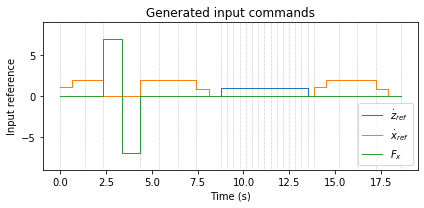

In [12]:
#plot the input sequence
Tsample = ts
k = 0
t = []
vz = []
vx = []
fx = []
for u in input_seq_a:
    type_in = u[2]
    t.append(k*Tsample)
    t.append((k+1)*Tsample)
    
    if type_in == 0:
        vz.append(0.0)
        vz.append(0.0)
        vx.append(0.0)
        vx.append(0.0)
        fx.append(u[1])
        fx.append(u[1])
    else:
        vz.append(u[0])
        vz.append(u[0])
        vx.append(u[1])
        vx.append(u[1])
        fx.append(0)
        fx.append(0)        
    k += 1

fig = plt.figure(figsize= [6, 3])
ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)
#ax.set_title('Desired Input Sequence')
ax.set_title(r'Generated input commands')
ax.set_xlabel(r'Time (s)')
ax.set_ylabel('Input reference')

#ax.axis([-0.1, 3.5, -5.9,  5.9])


#plt.ylim(ymin = -7.5, ymax =7.5)

t_pos = 0
plt.plot([0,0],[-9,9], color = 'grey', ls = ':', lw = 0.5)
for n in astar_search.path:
    duration = U[n.input_type].shape[0]
    plt.plot([t_pos + ts*duration,t_pos + ts*duration],[-9,9], color = 'grey', ls = ':', lw = 0.5)
    t_pos += ts*duration

plt.plot(t, vz,lw = 1, label = r"$\dot{z}_{ref}$")
plt.plot(t, vx,lw = 1, label = r"$\dot{x}_{ref}$")
plt.plot(t, fx,lw = 1, label = r"$F_{x}$")
plt.ylim(ymin = -9, ymax =9)

plt.legend(loc = 'lower right')
plt.tight_layout()
#plt.savefig('complex_pgf/comp_hor_input.pgf')

### Plot the states of the generated path

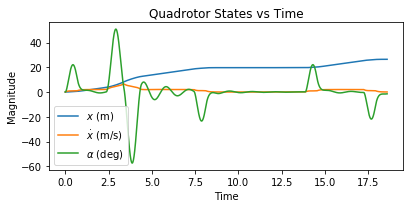

In [13]:
#plot the states for the input sequence
plt.rcParams['figure.figsize'] = 5.8, 3
quadrotor = Quadrotor(m=m)
result_a,t_a = quadrotor.solve(ts,xi,input_seq_a[:,0], input_seq_a[:,1],input_seq_a[:,2], t_eval = 0.001)
quadrotor.plot_states()
plt.tight_layout()

### Plot the nodes generated by the search algorithm

Number of nodes:  263


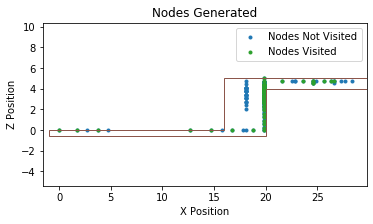

In [14]:
print ("Number of nodes: ",len(astar_search.nodes_list))
PlotPlanning.plot_nodes_astar(astar_search.nodes_list)
overlay_bounds()

### Plot the path executed

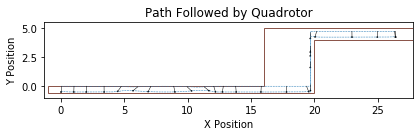

In [15]:
#plot the position of the quadrotor with suspended payload
fig = plt.figure(figsize=(5.8, 2))
plt.ylim(ymax = 5.5, ymin = -1)
positions = [0, 1000, 1500,2200,2700, 3000, 3200,3500,4000, 4200, 4500, 5000,3700, 6000, 
              7000, 8000,9000,11000,12000,12331, 13500, 14500, 16000, 17000, 18000,18172]
PlotPlanning.plot_position(result_a,t_a,positions )
plt.tight_layout()
overlay_bounds()
#plt.savefig('comp_tct_obs_path.png', dpi = 500)


## Export the planned path to a Matlab friendly environment

In [16]:
#Export the input sequence generated by the path planning algorithm
input_seq_a = astar_search.get_input_seq()
print ("The input sequence:")
print ("  r_z  r_x")
print (input_seq_a)
numbers_needed = input_seq_a.shape[0]
t = np.linspace(0,numbers_needed*ts,numbers_needed, endpoint = False)
rz = input_seq_a[:,0]
rx = input_seq_a[:,1]
input_type = input_seq_a[:,2]
sio.savemat('../example_trajectories/example3.mat', {'t':t.astype(float).T,'rz':rz.astype(float).T,'rx':rx.astype(float).T,'input_type':input_type.astype(float).T})

The input sequence:
  r_z  r_x
[[ 0.      1.1566  1.    ]
 [ 0.      1.1566  1.    ]
 [ 0.      2.      1.    ]
 [ 0.      2.      1.    ]
 [ 0.      2.      1.    ]
 [ 0.      2.      1.    ]
 [ 0.      2.      1.    ]
 [ 0.      7.      0.    ]
 [ 0.      7.      0.    ]
 [ 0.      7.      0.    ]
 [ 0.     -7.      0.    ]
 [ 0.     -7.      0.    ]
 [ 0.     -7.      0.    ]
 [ 0.      2.      1.    ]
 [ 0.      2.      1.    ]
 [ 0.      2.      1.    ]
 [ 0.      2.      1.    ]
 [ 0.      2.      1.    ]
 [ 0.      2.      1.    ]
 [ 0.      2.      1.    ]
 [ 0.      2.      1.    ]
 [ 0.      2.      1.    ]
 [ 0.      0.8434  1.    ]
 [ 0.      0.8434  1.    ]
 [ 0.      0.      1.    ]
 [ 0.      0.      1.    ]
 [ 1.      0.      2.    ]
 [ 1.      0.      2.    ]
 [ 1.      0.      2.    ]
 [ 1.      0.      2.    ]
 [ 1.      0.      2.    ]
 [ 1.      0.      2.    ]
 [ 1.      0.      2.    ]
 [ 1.      0.      2.    ]
 [ 1.      0.      2.    ]
 [ 1.      0.      2.   